# Analyzing the impact of Political and Economic Sentiment on Healthcare and Tech stock market Performance in Election Year 2024

## By: Dennis Goldenberg, Kevin Shao, and Samaa Nadkarni

In [19]:
import numpy as np
import pandas as pd
import scipy as sc
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from datetime import datetime, date

# Reading in the Data

In [60]:
(date(year = 2024, month = 12, day = 6) - date(year = 2024, month = 12, day = 2)).days

4

In [2]:
#trump's odds
trump_odds = pd.read_csv("data/Trump_implied_prob_victory_odds.csv")
trump_odds["DATE"] = trump_odds["Date (UTC)"].apply(lambda x: datetime.strptime(x,
                                                          '%m-%d-%Y 00:00').date())
trump_odds.drop(columns = ["Date (UTC)","Timestamp (UTC)"], inplace = True)
trump_odds.rename({"Price": "trump_odds"}, axis = 1,inplace = True)

#t-bills 2 Year
tbills_2Y = pd.read_csv("data/Tbills_2Y_mkt_yield.csv")
tbills_2Y['DATE'] = tbills_2Y['DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
#tbills_2Y['DGS2'] = tbills_2Y['DGS2'].astype(float)

#t-bills 10 Year
tbills_10Y = pd.read_csv("data/Tbills_10Y_mkt_yield.csv")
tbills_10Y['DATE'] = tbills_10Y['DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
#tbills_10Y['DGS10'] = tbills_2Y['DGS10'].astype(float)

#Other Project Data
other_data = pd.read_csv("data/Project Data V1.csv")
other_data["DATE"] = other_data["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
other_data.drop(columns = ['date', 'Gold_Price', 'Oil_Price','Gold_Volume',
                           'Oil_Volume'], inplace = True)

#Continue merging procedure
result_Frame = pd.merge(left = pd.merge(left = pd.merge(left = tbills_2Y, 
                                         right = tbills_10Y, 
                                         on = 'DATE'),
                right = trump_odds,
                on = 'DATE'),
         right = other_data,
         on = 'DATE')

In [3]:
columns = np.append(result_Frame.columns.values[-9], 
          np.append(result_Frame.columns.values[-5:-3],
          np.append(result_Frame.columns.values[-8:-5],
                    result_Frame.columns.values[-3:])))
raw_data = result_Frame.copy()[columns]

## Linearly interpolating to fill in missing gaps on market yield Time Series

In [5]:
def interp(dates, array_vals):
    ret_vec = np.empty(shape = (len(array_vals)))
    for i in range(len(array_vals)):
        if array_vals[i] == '.':
            if i == 0:
                delta_0 = (dates[i + 1] - dates[i]).days
                delta_1 = (dates[i + 2] - dates[i + 1]).days
                ret_vec[i] = float(array_vals[i + 1]) - (delta_0/delta_1)(float(array_vals[i + 2]) - float(array_vals[i + 1]))
            elif i == len(array_vals) - 1:
                delta_0 = (dates[i] - dates[i - 1]).days
                delta_1 = (dates[i - 1] - dates[i - 2]).days
                ret_vec[i] = float(array_vals[i - 1]) + (delta_0/delta_1)(float(array_vals[i - 1]) - float(array_vals[i - 2]))
            else:
                delta_0 = (dates[i] - dates[i - 1]).days
                delta_1 = (dates[i + 1] - dates[i - 1]).days
                ret_vec[i] = (delta_0/delta_1)*float(array_vals[i - 1]) + (1 - delta_0/delta_1)*float(array_vals[i + 1])
        else:
            ret_vec[i] = array_vals[i]
    return ret_vec.astype(float)

In [6]:
raw_data['DGS2'] = interp(raw_data['DATE'], raw_data['DGS2'])
raw_data['DGS10'] = interp(raw_data['DATE'], raw_data['DGS10'])

In [7]:
raw_data[raw_data.columns.values[1:]].cov()

,NASDAQ 100 Tech Index,S&P Healthcare Index,DGS2,DGS10,trump_odds,Dollar_Index,BEIR,VIX index
NASDAQ 100 Tech Index,150692.355611,6015.810965,18.138936,13.686925,13.345162,107.874882,4.854586,-440.367200
S&P Healthcare Index,6015.810965,3306.457038,-18.525852,-10.687684,0.625182,-57.739882,-3.754969,80.103698
DGS2,18.138936,-18.525852,0.169993,0.097405,-0.000854,0.525705,0.029658,-0.773109
DGS10,13.686925,-10.687684,0.097405,0.065899,0.000494,0.340163,0.021317,-0.319980
trump_odds,13.345162,0.625182,-0.000854,0.000494,0.003536,0.015669,0.000077,0.002571
Dollar_Index,107.874882,-57.739882,0.525705,0.340163,0.015669,2.155076,0.101257,-1.609284
BEIR,4.854586,-3.754969,0.029658,0.021317,0.000077,0.101257,0.008869,-0.109777
VIX index,-440.367200,80.103698,-0.773109,-0.319980,0.002571,-1.609284,-0.109777,11.992258


In [8]:
raw_data[raw_data.columns.values[1:]].corr()
#Dollar Index and BEIR closely correlated, likely will use BEIR, we will keep this in mind

,NASDAQ 100 Tech Index,S&P Healthcare Index,DGS2,DGS10,trump_odds,Dollar_Index,BEIR,VIX index
NASDAQ 100 Tech Index,1.000000,0.269505,0.113331,0.137348,0.578086,0.189297,0.133364,-0.327581
S&P Healthcare Index,0.269505,1.000000,-0.781413,-0.724043,0.182827,-0.684011,-0.696095,0.402273
DGS2,0.113331,-0.781413,1.000000,0.920299,-0.034817,0.868550,0.764104,-0.541470
DGS10,0.137348,-0.724043,0.920299,1.000000,0.032334,0.902646,0.880081,-0.359944
trump_odds,0.578086,0.182827,-0.034817,0.032334,1.000000,0.179487,0.013731,0.012486
Dollar_Index,0.189297,-0.684011,0.868550,0.902646,0.179487,1.000000,0.730863,-0.316556
BEIR,0.133364,-0.696095,0.764104,0.880081,0.013731,0.730863,1.000000,-0.336911
VIX index,-0.327581,0.402273,-0.541470,-0.359944,0.012486,-0.316556,-0.336911,1.000000


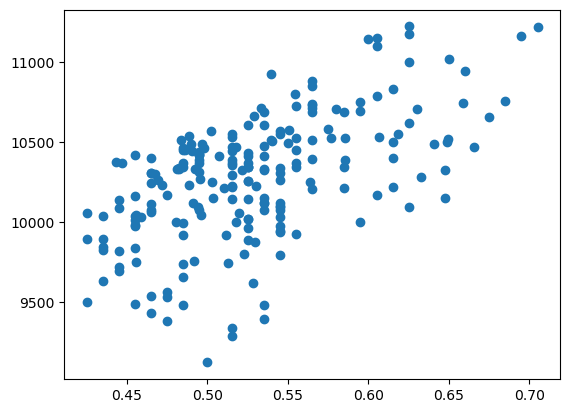

In [9]:
plt.scatter(raw_data['trump_odds'], raw_data['NASDAQ 100 Tech Index'])
plt.show()

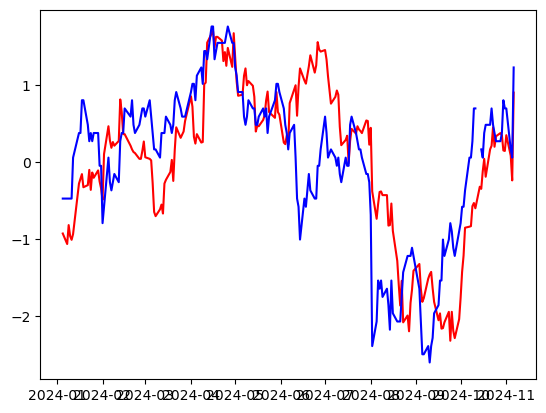

In [10]:
plt.plot(raw_data['DATE'], (raw_data['Dollar_Index'] - np.mean(raw_data['Dollar_Index']))/np.std(raw_data['Dollar_Index']), color = 'red')
plt.plot(raw_data['DATE'], (raw_data['BEIR'] - np.mean(raw_data['BEIR']))/np.std(raw_data['BEIR']), color = 'blue')
plt.show()

# Data Preprocessing

## Examining Stationarity

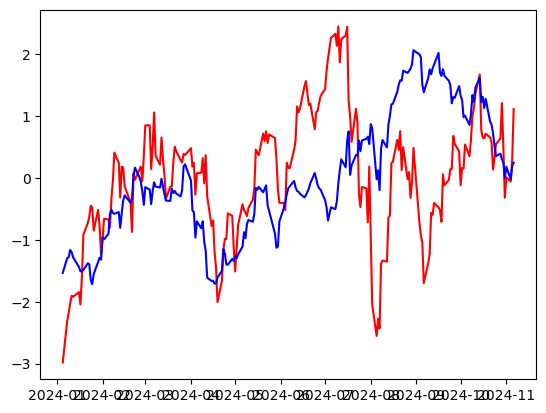

In [14]:
plt.plot(raw_data['DATE'], 
         (raw_data['NASDAQ 100 Tech Index'] - np.mean(raw_data['NASDAQ 100 Tech Index']))/np.std(raw_data['NASDAQ 100 Tech Index']),
          color = 'red')
plt.plot(raw_data['DATE'], 
         (raw_data['S&P Healthcare Index'] - np.mean(raw_data['S&P Healthcare Index']))/np.std(raw_data['S&P Healthcare Index']),
          color = 'blue')
plt.show()

In [55]:
#Stationarity Analysis
test_1 = adfuller(raw_data['NASDAQ 100 Tech Index'])
print(f'ADF Statistic: {test_1[0]}')
print(f'p-value: {test_1[1]}')
for key, value in test_1[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.661804239548556
p-value: 0.004683641110341482
Critial Values:
   1%, -3.46172743446274
Critial Values:
   5%, -2.8753374677799957
Critial Values:
   10%, -2.574124089081557


In [25]:
test_2 = adfuller(raw_data['S&P Healthcare Index'])
print(f'ADF Statistic: {test_2[0]}')
print(f'p-value: {test_2[1]}')
for key, value in test_2[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.825068981875701
p-value: 0.36808856903609166
Critial Values:
   1%, -3.46172743446274
Critial Values:
   5%, -2.8753374677799957
Critial Values:
   10%, -2.574124089081557


So, according to the ADF test, the S&P Healthcare index isn't stationary, but the NASDAQ 100 tech index is. I difference the S&P Healthcare Index series and than model again:

ADF Statistic: -14.494243130073329
p-value: 6.077736548238598e-27
Critial Values:
   1%, -3.461878735881654
Critial Values:
   5%, -2.875403665910809
Critial Values:
   10%, -2.574159410430839


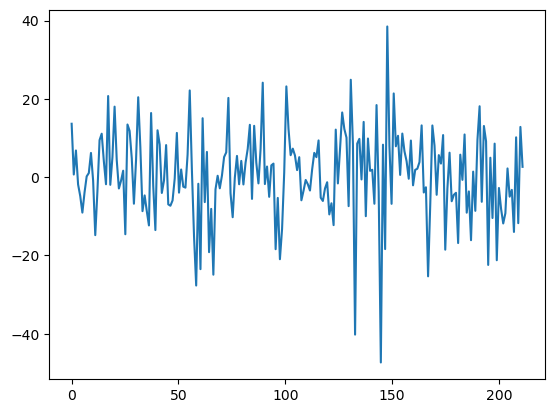

In [ ]:
differenced_healthcare = raw_data['S&P Healthcare Index'][1:].values - raw_data['S&P Healthcare Index'][0:(len(raw_data['S&P Healthcare Index']) - 1)]
test_3 = adfuller(differenced_healthcare)
print(f'ADF Statistic: {test_3[0]}')
print(f'p-value: {test_3[1]}')
for key, value in test_3[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

## Cross correlelograms

In [56]:
result_data = raw_data[0:(len(raw_data) - 1)][['NASDAQ 100 Tech Index',
                                                'S&P Healthcare Index',
                            'trump_odds', 'BEIR', 'VIX index']].copy()
result_data['S&P Healthcare Index'] = differenced_healthcare